<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/open-mic/open_mic_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. mount the google drive






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


define the file location

In [ ]:
import os

# Define the path to the extracted directory
dataset_path = '/content/drive/My Drive/datasets/openmic-2018/openmic-2018/'

# List the contents of the directory
for root, dirs, files in os.walk(dataset_path):
    print(root, "contains", len(files), "files and", len(dirs), "directories")

In [ ]:
import pandas as pd

# Define paths to metadata and partition files
metadata_file = os.path.join(dataset_path, 'openmic-2018-aggregated-labels.csv')
partition_file = os.path.join(dataset_path, 'partitions/split01_train.csv')

# Load metadata
metadata = pd.read_csv(metadata_file)
partition_csv = pd.read_csv(partition_file)

# Load partition (example for training set)
train_partition = pd.read_csv(partition_file, header=None)
train_samples = train_partition[0].tolist()

# Print first few rows of metadata
print(partition_csv.head())
print(metadata.head())

     000046_3840
0  000135_483840
1  000139_119040
2  000141_153600
3   000144_30720
4  000145_172800
      sample_key instrument  relevance  num_responses
0    000046_3840   clarinet    0.17105              3
1    000046_3840      flute    0.00000              3
2    000046_3840    trumpet    0.00000              3
3  000135_483840  saxophone    0.14705              3
4  000135_483840      voice    1.00000              3


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot waveform and spectrogram
def plot_audio_sample(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Plot the waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.show()

    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

# Path to an audio sample (replace with an actual file from your dataset)
audio_sample = os.path.join(dataset_path, 'audio/000/', '000046_3840.ogg')

# Plot the audio sample
plot_audio_sample(audio_sample)


In [ ]:
import seaborn as sns

# Count the occurrences of each instrument
instrument_counts = metadata['instrument'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=instrument_counts.index, y=instrument_counts.values)
plt.xlabel('Instrument')
plt.ylabel('Count')
plt.title('Instrument Distribution in OpenMIC-2018 Dataset')
plt.xticks(rotation=90)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
import gc
import cv2
import h5py
import librosa.display
import numpy as np
import pandas as pd

# Function to resize features
def resize_feature(feature, new_height):
    return cv2.resize(feature, (feature.shape[1], new_height), interpolation=cv2.INTER_LINEAR)

def normalize_feature(feature):
    # Min-max normalization to scale the values to the range [0, 1]
    min_val = np.min(feature)
    max_val = np.max(feature)
    return (feature - min_val) / (max_val - min_val)

def extract_logmel_cst_features(sample):
    audio_file = os.path.join(dataset_path, 'audio', sample[:3], sample + '.ogg')
    y, sr = librosa.load(audio_file)

    # Log-mel spectrogram (height=128)
    logmel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    logmel_spectrogram = librosa.power_to_db(logmel_spectrogram, ref=np.max)

    # Normalize log-mel spectrogram
    logmel_spectrogram = normalize_feature(logmel_spectrogram)

    # CST features
    chroma_feature = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast_feature = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz_feature = librosa.feature.tonnetz(y=y, sr=sr)

    # Normalize CST features
    chroma_feature = normalize_feature(chroma_feature)
    spectral_contrast_feature = normalize_feature(spectral_contrast_feature)
    tonnetz_feature = normalize_feature(tonnetz_feature)

    # Resize CST features to height 30
    chroma_feature_resized = resize_feature(chroma_feature, 30)
    spectral_contrast_feature_resized = resize_feature(spectral_contrast_feature, 30)
    tonnetz_feature_resized = resize_feature(tonnetz_feature, 30)

    # Combine features
    combined_feature = np.concatenate([
        logmel_spectrogram,
        chroma_feature_resized,
        spectral_contrast_feature_resized,
        tonnetz_feature_resized
    ], axis=0)

    # Resize the combined feature to width 800
    combined_feature_resized = cv2.resize(combined_feature, (800, combined_feature.shape[0]), interpolation=cv2.INTER_LINEAR)

    return combined_feature_resized

def save_spectrograms_to_hdf5(samples, feature_func, hdf5_file_path):
    with h5py.File(hdf5_file_path, 'w') as hdf5_file:
        for i, sample in enumerate(samples):
            try:
                sample_metadata = metadata[metadata["sample_key"] == sample]
                file_path = os.path.join(dataset_path, "audio", sample[:3], sample)

                # Extract combined features
                features = feature_func(file_path)
                hdf5_file.create_dataset(sample, data=features)

                # Print the checkpoint message
                if i % 100 == 0:
                    print(f"Spectrogram for {sample} saved to HDF5 file (sample {i + 1})")

                # Explicitly delete variables to free memory
                del features
                gc.collect()
            except Exception as e:
                print(f"Error processing file {file_path} for sample {sample}: {e}")
                continue

In [ ]:
# Define paths to metadata and partition files
metadata_file = os.path.join(dataset_path, 'openmic-2018-aggregated-labels.csv')
partition_file = os.path.join(dataset_path, 'partitions/split01_train.csv')

# Load metadata
metadata = pd.read_csv(metadata_file)
partition_csv = pd.read_csv(partition_file)

# Load partition (example for training set)
train_partition = pd.read_csv(partition_file, header=None)
# train_samples = train_partition[0].tolist()[:5]  # Use only 5 samples for training
train_samples = train_partition[0].tolist()

# Define paths to testing partition
test_partition_file = os.path.join(dataset_path, 'partitions/split01_test.csv')
test_partition = pd.read_csv(test_partition_file, header=None)
# test_samples = test_partition[0].tolist()[:5]  # Use only 5 samples for testing
test_samples = test_partition[0].tolist()

train_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/train_spectrograms.h5'
test_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/test_spectrograms.h5'

feature_func = extract_logmel_cst_features

# Save training data
save_spectrograms_to_hdf5(train_samples, feature_func, train_hdf5_file_path)
print("------------Training End----------")
# Save testing data
save_spectrograms_to_hdf5(test_samples, feature_func, test_hdf5_file_path)

Spectrogram for 000046_3840 saved to HDF5 file (sample 1)
Spectrogram for 001050_0 saved to HDF5 file (sample 101)
Spectrogram for 003260_145920 saved to HDF5 file (sample 201)
Spectrogram for 004041_291840 saved to HDF5 file (sample 301)
Spectrogram for 005050_115200 saved to HDF5 file (sample 401)
Spectrogram for 007045_165120 saved to HDF5 file (sample 501)
Spectrogram for 008991_38400 saved to HDF5 file (sample 601)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 010043_42240 saved to HDF5 file (sample 701)
Spectrogram for 010956_1052160 saved to HDF5 file (sample 801)
Spectrogram for 011583_172800 saved to HDF5 file (sample 901)
Spectrogram for 012467_917760 saved to HDF5 file (sample 1001)
Spectrogram for 013056_76800 saved to HDF5 file (sample 1101)
Spectrogram for 013784_61440 saved to HDF5 file (sample 1201)
Spectrogram for 014633_84480 saved to HDF5 file (sample 1301)
Spectrogram for 015588_1612800 saved to HDF5 file (sample 1401)
Spectrogram for 016655_96000 saved to HDF5 file (sample 1501)
Spectrogram for 017467_3840 saved to HDF5 file (sample 1601)
Spectrogram for 018630_218880 saved to HDF5 file (sample 1701)
Spectrogram for 019695_19200 saved to HDF5 file (sample 1801)
Spectrogram for 020935_161280 saved to HDF5 file (sample 1901)
Spectrogram for 021915_222720 saved to HDF5 file (sample 2001)
Spectrogram for 023279_3840 saved to HDF5 file (sample 2101)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 024691_19200 saved to HDF5 file (sample 2201)
Spectrogram for 025735_272640 saved to HDF5 file (sample 2301)
Spectrogram for 026820_122880 saved to HDF5 file (sample 2401)
Spectrogram for 027967_119040 saved to HDF5 file (sample 2501)
Spectrogram for 028891_61440 saved to HDF5 file (sample 2601)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 029801_990720 saved to HDF5 file (sample 2701)
Spectrogram for 030677_2342400 saved to HDF5 file (sample 2801)
Spectrogram for 031706_65280 saved to HDF5 file (sample 2901)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 032570_215040 saved to HDF5 file (sample 3001)
Spectrogram for 033434_138240 saved to HDF5 file (sample 3101)
Spectrogram for 034507_230400 saved to HDF5 file (sample 3201)
Spectrogram for 035482_115200 saved to HDF5 file (sample 3301)
Spectrogram for 036366_380160 saved to HDF5 file (sample 3401)
Spectrogram for 037608_238080 saved to HDF5 file (sample 3501)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 038778_69120 saved to HDF5 file (sample 3601)
Spectrogram for 039540_387840 saved to HDF5 file (sample 3701)
Spectrogram for 040424_226560 saved to HDF5 file (sample 3801)
Spectrogram for 041228_165120 saved to HDF5 file (sample 3901)
Spectrogram for 042061_80640 saved to HDF5 file (sample 4001)
Spectrogram for 042960_42240 saved to HDF5 file (sample 4101)
Spectrogram for 043655_307200 saved to HDF5 file (sample 4201)
Spectrogram for 044821_42240 saved to HDF5 file (sample 4301)
Spectrogram for 045955_115200 saved to HDF5 file (sample 4401)
Spectrogram for 047089_76800 saved to HDF5 file (sample 4501)
Spectrogram for 047896_46080 saved to HDF5 file (sample 4601)
Spectrogram for 048763_7680 saved to HDF5 file (sample 4701)
Spectrogram for 049647_349440 saved to HDF5 file (sample 4801)
Spectrogram for 050777_15360 saved to HDF5 file (sample 4901)
Spectrogram for 051543_249600 saved to HDF5 file (sample 5001)
Spectrogram for 052302_34560 saved to HDF5 file (sample 5101)
Sp

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 053830_65280 saved to HDF5 file (sample 5301)
Spectrogram for 054787_1025280 saved to HDF5 file (sample 5401)
Spectrogram for 056068_61440 saved to HDF5 file (sample 5501)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 057331_19200 saved to HDF5 file (sample 5601)
Spectrogram for 058239_253440 saved to HDF5 file (sample 5701)
Spectrogram for 058781_172800 saved to HDF5 file (sample 5801)
Spectrogram for 058924_103680 saved to HDF5 file (sample 5901)
Spectrogram for 059377_161280 saved to HDF5 file (sample 6001)
Spectrogram for 060101_0 saved to HDF5 file (sample 6101)
Spectrogram for 060901_11520 saved to HDF5 file (sample 6201)
Spectrogram for 062094_176640 saved to HDF5 file (sample 6301)
Spectrogram for 062977_42240 saved to HDF5 file (sample 6401)
Spectrogram for 064187_184320 saved to HDF5 file (sample 6501)
Spectrogram for 065080_222720 saved to HDF5 file (sample 6601)
Spectrogram for 065650_207360 saved to HDF5 file (sample 6701)
Spectrogram for 066702_414720 saved to HDF5 file (sample 6801)
Spectrogram for 067579_3840 saved to HDF5 file (sample 6901)
Spectrogram for 068807_349440 saved to HDF5 file (sample 7001)
Spectrogram for 069685_395520 saved to HDF5 file (sample 7101)
Sp

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 091966_184320 saved to HDF5 file (sample 9001)
Spectrogram for 093119_3840 saved to HDF5 file (sample 9101)
Spectrogram for 094346_7680 saved to HDF5 file (sample 9201)
Spectrogram for 095893_65280 saved to HDF5 file (sample 9301)
Spectrogram for 097396_157440 saved to HDF5 file (sample 9401)
Spectrogram for 098459_165120 saved to HDF5 file (sample 9501)
Spectrogram for 099443_69120 saved to HDF5 file (sample 9601)
Spectrogram for 102110_99840 saved to HDF5 file (sample 9701)
Spectrogram for 104334_76800 saved to HDF5 file (sample 9801)
Spectrogram for 105460_15360 saved to HDF5 file (sample 9901)
Spectrogram for 106447_7680 saved to HDF5 file (sample 10001)
Spectrogram for 107509_176640 saved to HDF5 file (sample 10101)
Spectrogram for 108244_96000 saved to HDF5 file (sample 10201)
Spectrogram for 109176_245760 saved to HDF5 file (sample 10301)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 110241_96000 saved to HDF5 file (sample 10401)
Spectrogram for 111120_26880 saved to HDF5 file (sample 10501)
Spectrogram for 112156_353280 saved to HDF5 file (sample 10601)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 112808_3874560 saved to HDF5 file (sample 10701)
Spectrogram for 113603_72960 saved to HDF5 file (sample 10801)
Spectrogram for 114641_360960 saved to HDF5 file (sample 10901)
Spectrogram for 115775_138240 saved to HDF5 file (sample 11001)
Spectrogram for 116537_142080 saved to HDF5 file (sample 11101)
Spectrogram for 117917_130560 saved to HDF5 file (sample 11201)
Spectrogram for 118724_61440 saved to HDF5 file (sample 11301)
Spectrogram for 119598_96000 saved to HDF5 file (sample 11401)
Spectrogram for 120407_15360 saved to HDF5 file (sample 11501)
Spectrogram for 120934_88320 saved to HDF5 file (sample 11601)
Spectrogram for 122195_7680 saved to HDF5 file (sample 11701)
Spectrogram for 123479_145920 saved to HDF5 file (sample 11801)
Spectrogram for 124408_65280 saved to HDF5 file (sample 11901)
Spectrogram for 125131_303360 saved to HDF5 file (sample 12001)
Spectrogram for 126216_26880 saved to HDF5 file (sample 12101)
Spectrogram for 127182_11520 saved to HDF5 file 

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 132999_184320 saved to HDF5 file (sample 12801)
Spectrogram for 133874_3840 saved to HDF5 file (sample 12901)
Spectrogram for 134921_579840 saved to HDF5 file (sample 13001)
Spectrogram for 136086_42240 saved to HDF5 file (sample 13101)
Spectrogram for 137407_7680 saved to HDF5 file (sample 13201)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 138212_15360 saved to HDF5 file (sample 13301)
Spectrogram for 139086_510720 saved to HDF5 file (sample 13401)
Spectrogram for 140054_53760 saved to HDF5 file (sample 13501)
Spectrogram for 141124_222720 saved to HDF5 file (sample 13601)
Spectrogram for 142507_122880 saved to HDF5 file (sample 13701)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 143600_111360 saved to HDF5 file (sample 13801)
Spectrogram for 144726_188160 saved to HDF5 file (sample 13901)
Spectrogram for 145395_529920 saved to HDF5 file (sample 14001)
Spectrogram for 146157_184320 saved to HDF5 file (sample 14101)
Spectrogram for 147173_122880 saved to HDF5 file (sample 14201)
Spectrogram for 148378_314880 saved to HDF5 file (sample 14301)
Spectrogram for 149143_99840 saved to HDF5 file (sample 14401)
Spectrogram for 150084_165120 saved to HDF5 file (sample 14501)
Spectrogram for 151181_203520 saved to HDF5 file (sample 14601)
Spectrogram for 152566_138240 saved to HDF5 file (sample 14701)
Spectrogram for 154324_84480 saved to HDF5 file (sample 14801)
Spectrogram for 155116_99840 saved to HDF5 file (sample 14901)
------------Training End----------
Spectrogram for 000178_3840 saved to HDF5 file (sample 1)
Spectrogram for 003661_111360 saved to HDF5 file (sample 101)
Spectrogram for 006383_134400 saved to HDF5 file (sample 201)
Spectrogram for 01

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 037099_257280 saved to HDF5 file (sample 1101)
Spectrogram for 040148_49920 saved to HDF5 file (sample 1201)
Spectrogram for 043322_376320 saved to HDF5 file (sample 1301)
Spectrogram for 047268_92160 saved to HDF5 file (sample 1401)
Spectrogram for 049100_0 saved to HDF5 file (sample 1501)
Spectrogram for 053150_7680 saved to HDF5 file (sample 1601)
Spectrogram for 055944_15360 saved to HDF5 file (sample 1701)
Spectrogram for 058660_257280 saved to HDF5 file (sample 1801)
Spectrogram for 059821_272640 saved to HDF5 file (sample 1901)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 062486_322560 saved to HDF5 file (sample 2001)
Spectrogram for 065163_49920 saved to HDF5 file (sample 2101)
Spectrogram for 066779_42240 saved to HDF5 file (sample 2201)
Spectrogram for 070283_272640 saved to HDF5 file (sample 2301)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 073906_92160 saved to HDF5 file (sample 2401)
Spectrogram for 076613_72960 saved to HDF5 file (sample 2501)
Spectrogram for 081059_23040 saved to HDF5 file (sample 2601)
Spectrogram for 083771_19200 saved to HDF5 file (sample 2701)
Spectrogram for 086439_38400 saved to HDF5 file (sample 2801)
Spectrogram for 090775_218880 saved to HDF5 file (sample 2901)
Spectrogram for 095040_326400 saved to HDF5 file (sample 3001)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 097623_572160 saved to HDF5 file (sample 3101)
Spectrogram for 102193_34560 saved to HDF5 file (sample 3201)
Spectrogram for 106405_0 saved to HDF5 file (sample 3301)
Spectrogram for 107339_46080 saved to HDF5 file (sample 3401)
Spectrogram for 111163_161280 saved to HDF5 file (sample 3501)
Spectrogram for 113322_188160 saved to HDF5 file (sample 3601)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Spectrogram for 116677_0 saved to HDF5 file (sample 3701)
Spectrogram for 118899_99840 saved to HDF5 file (sample 3801)
Spectrogram for 121788_111360 saved to HDF5 file (sample 3901)
Spectrogram for 124154_142080 saved to HDF5 file (sample 4001)
Spectrogram for 127367_72960 saved to HDF5 file (sample 4101)
Spectrogram for 129430_261120 saved to HDF5 file (sample 4201)
Spectrogram for 132767_226560 saved to HDF5 file (sample 4301)
Spectrogram for 136081_61440 saved to HDF5 file (sample 4401)
Spectrogram for 139741_92160 saved to HDF5 file (sample 4501)
Spectrogram for 142198_96000 saved to HDF5 file (sample 4601)
Spectrogram for 144481_245760 saved to HDF5 file (sample 4701)
Spectrogram for 146953_257280 saved to HDF5 file (sample 4801)
Spectrogram for 149806_126720 saved to HDF5 file (sample 4901)
Spectrogram for 152685_238080 saved to HDF5 file (sample 5001)


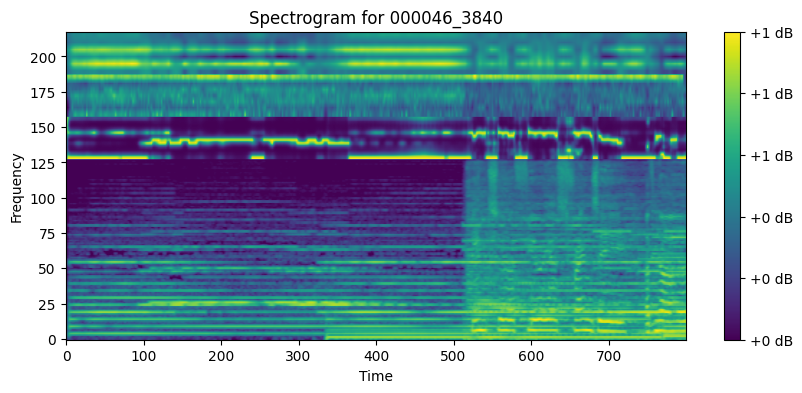

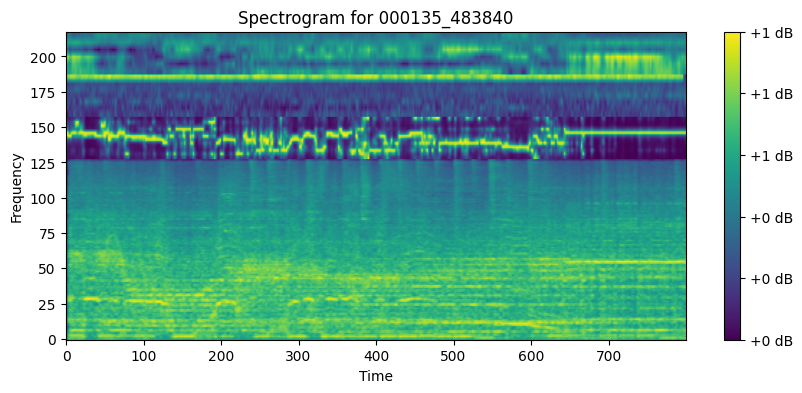

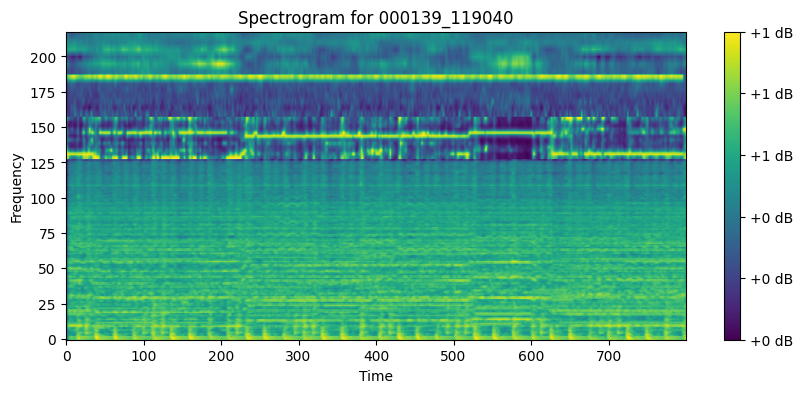

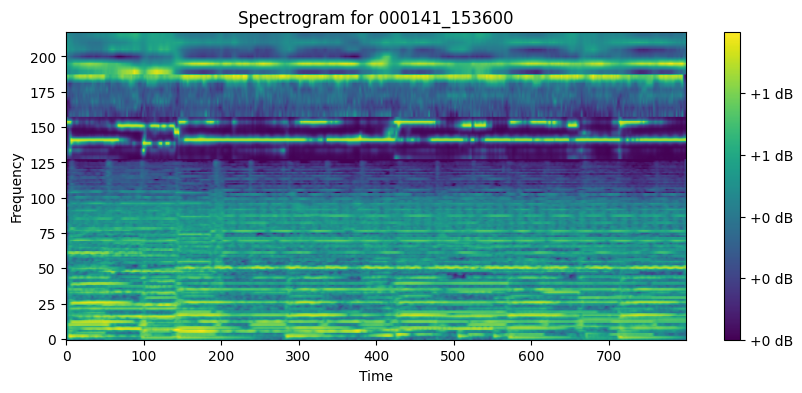

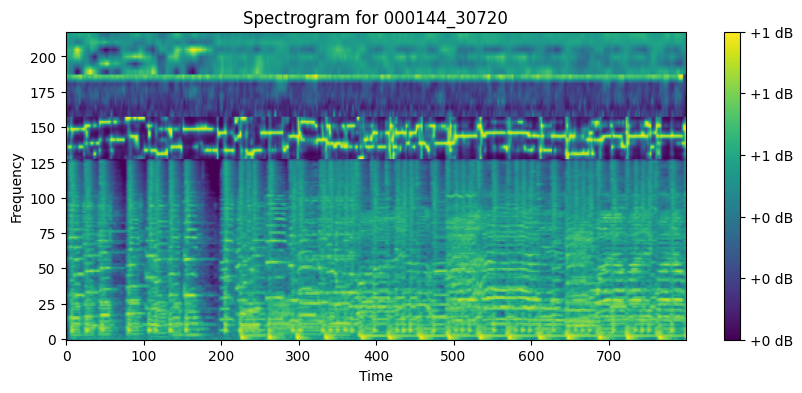

In [ ]:
import h5py
import matplotlib.pyplot as plt

def plot_all_spectrograms_from_hdf5(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        sample_keys = list(hdf5_file.keys())[:5]  # Convert KeysView to list
        for sample_key in sample_keys:
            spectrogram = hdf5_file[sample_key][:]
            plt.figure(figsize=(10, 4))
            plt.imshow(spectrogram, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Spectrogram for {sample_key}')
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            plt.show()


plot_all_spectrograms_from_hdf5(train_hdf5_file_path)
